# **<center>Differentiable Sampling</center>**
This is a development notebook used to develop ideas which are then moved once solidated to proper modules.

## Probability Density Functions

A probability density function $\mathcal{f}(\mathbf{x};\mu)\,,$ where:
-  $\mathbf{x}$ is the spatial coordinate points,
-  $\mu$ is the PDF parameters.

### Examples:
- 1D Gaussian:
  - PDF
  - CDF
    
- ND Gaussian:
  - PDF
  - CDF

- IDIS:

## Differentiability of a Probability Density Function

$$\frac{\partial{\mathcal{f}}}{\partial{x}}\, |_{\mu}$$
  - Sensitivity of the density $\mathcal{f}$ w.r.t changes in coordinates $\mathbf{x}$ for a given parameter $\mu$
  - How steep is the density curve/surface at $\mathbf{x}$ for fixed parameter$\mu$.

$$\frac{\partial{\mathcal{f}}}{\partial{\mu}}\, |_{x}$$
  - Sensitivity of the density $\mathcal{f}$ w.r.t changes in coordinates the parameter $\mu$ at a given coordinate point $\mathbf{x}$
  - How sensitive is the density curve for purterbation in the parameter $\mu$ at a given coordinate point $\mathbf{x}$.

$$\frac{\partial{\mathbf{x}}}{\partial{\mu}}$$
  - **What does this mean?**
  - **Is it even well-defined for ND? Why?**
  - **Is it well-defined for 1D? Why?**

## One-Dimensional Analysis

### PDF, CDF, ICDF: 
**Illustration using a one dimensional Gaussian distribution**

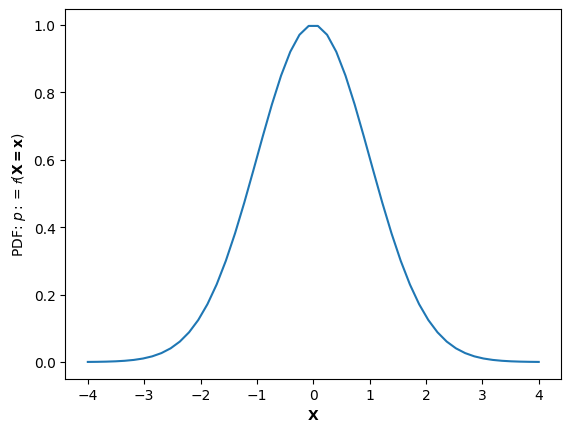

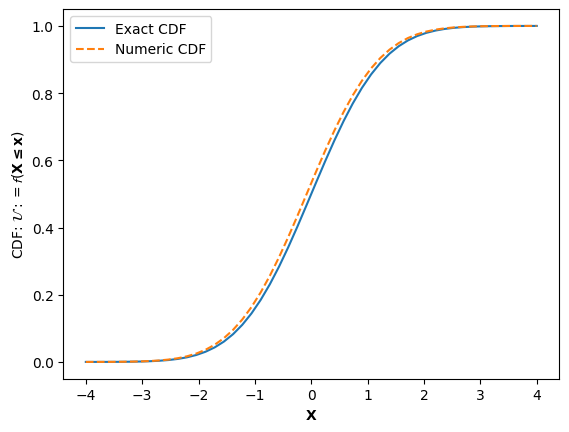

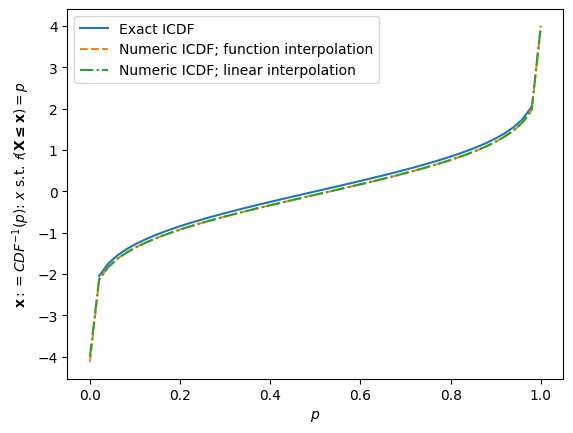

In [1]:
import numpy as np
import distributions
import matplotlib.pyplot as plt
plt.rc({"text.usetex": True})

# Number of discretization gridpoints (NOTE: larger --> better approximation but expensive)
num_gridpoints = 50

# Create 1D Gaussian/Normal
dist = distributions.OneDimensionalGaussian(mean=0, variance=1)

# Create a discretization grid
x_grid = np.linspace(-4, 4, num_gridpoints)

## Evaluate PDF at all grid points (and plot it)
# Evaluate PDF values
pdf_vals = [dist.pdf(x) for x in x_grid]
# Plot PDF values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_grid, pdf_vals)
ax.set_xlabel(r"$\mathbf{X}$")
ax.set_ylabel(r"PDF: $p:=\mathcal{f}(\mathbf{X=x})$")

## Evaluate CDF at all grid points; both exactly & by accumulating densities & Plot them
# Evaluate (both exact and numeric)
exact_cdf_vals = [dist.cdf(x) for x in x_grid]
numeric_cdf_vals = [sum(pdf_vals[: i])/sum(pdf_vals) for i in range(1, len(pdf_vals)+1)]  # NOTE: must be normalized numerically
# Plot both exact and numeric CDF values
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(x_grid, exact_cdf_vals, '-', label=r"Exact CDF")
ax.plot(x_grid, numeric_cdf_vals, '--', label=r"Numeric CDF")
ax.set_xlabel("$\mathbf{X}$")
ax.set_ylabel("CDF: $\mathcal{U}:=\mathcal{f}(\mathbf{X\leq x})$")
ax.legend()

# Evaluate CDF at all grid points; both by numericall (flip numerical CDF + interpolation) and exactly
probabilities = np.linspace(0, 1, num_gridpoints)
exact_icdf_vals = [dist.icdf(p) for p in probabilities]
numeric_icdf_vals_splines = [dist.numeric_icdf(x, x_grid=x_grid, cdf_vals=numeric_cdf_vals, interpolate_first=True) for x in probabilities]
numeric_icdf_vals = [dist.numeric_icdf(x, x_grid=x_grid, cdf_vals=numeric_cdf_vals, interpolate_first=False) for x in probabilities]
# Plot both exact and numeric ICDF
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(probabilities, exact_icdf_vals, '-', label=r"Exact ICDF")
ax.plot(probabilities, numeric_icdf_vals_splines, '--', label=r"Numeric ICDF; function interpolation")
ax.plot(probabilities, numeric_icdf_vals, '-.', label=r"Numeric ICDF; linear interpolation")
ax.set_xlabel("$p$")
ax.set_ylabel("$\mathbf{x}:=CDF^{-1}(p)$: $x$ s.t. $\mathcal{f}(\mathbf{X\leq x})=p$")
ax.legend()


- The CDF enables defining the following:
    Consider a random variable $x$ having a PDF with parameter $\mu$.
    For a domain $[a, b]$; let $u$ be a uniform random variable with probability $\frac{1}{b-a}$, then: 
    - $u = CDF(x; \mu)$
    - $x = CDF^{-1}(u; \mu) $
    - $\rightarrow x = CDF^{-1}(CDF(x; \mu); \mu)$
      
- Thus, the inverse CDF is a valid (unique) function that depends on both $x$ and $\mu$.
- One can define the following derivatives (all valid) for any 1D PDF:
    - $\frac{\partial f(x; \mu)}{\partial x}$
    - $\frac{\partial f(x; \mu)}{\partial \mu}$
    - $\frac{\partial x}{\partial \mu} = \frac{\partial CDF^{-1}(u; \mu)}{\partial \mu} = \frac{\partial CDF^{-1}(CDF(x; \mu); \mu)}{\partial \mu}$
    - $\frac{\partial x}{\partial \mu} 
        = \frac{\partial x}{\partial u} \frac{\partial u}{\partial \mu}
        = \frac{\partial CDF^{-1}(u; \mu)}{\partial u}|_{u=CDF(x)} \frac{\partial CDF(x; \mu)}{\partial \mu} 
      $
    
- **This means that we can evaluate the sensitivity of gridpoints $x$ with respect to purturbations of the parameter $\mu$ by mapping to the cumulative density space.**

<h3><center><mark>But still, what does it REALLY mean?!</mark></center></h3>

### Function composition

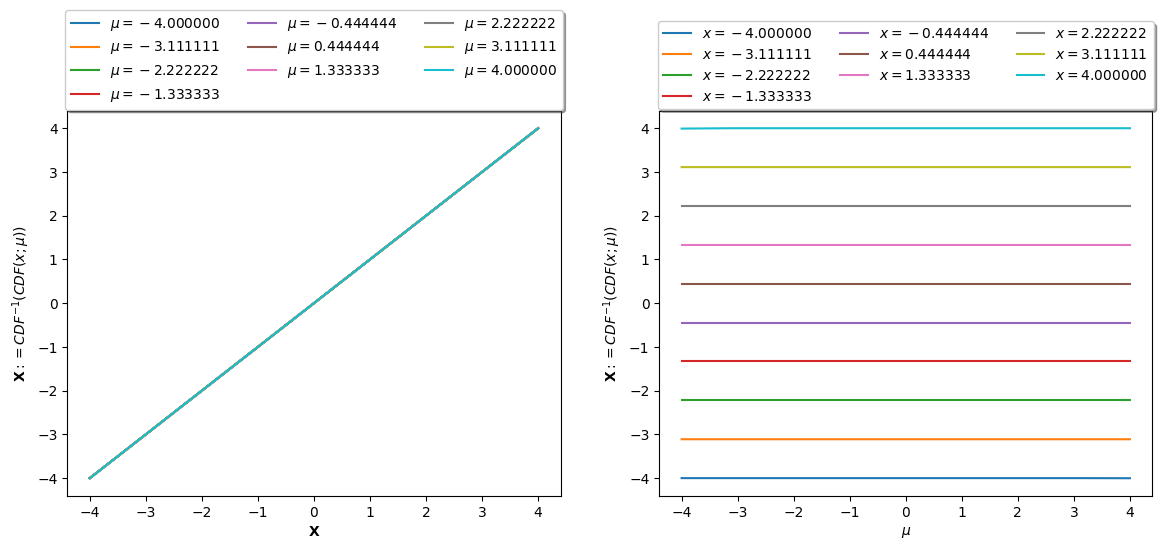

In [2]:
import numpy as np
import distributions
import matplotlib.pyplot as plt
plt.rc({"text.usetex": True})

# Number of discretization gridpoints (NOTE: larger --> better approximation but expensive)
num_gridpoints = 10

# Define $x$ as a function of $\mu$ the distribution mean and/or variance
def x_as_function_of_param(x, mu=0.0, sigma2=1.0):
    g = distributions.OneDimensionalGaussian(mean=mu, variance=sigma2)
    return g.icdf(g.cdf(x))

# Plot x as a function of the Gaussian mean (for fixed variance of 1)
x_vals = np.linspace(-4, 4, num_gridpoints)
mu_vals = np.linspace(-4, 4, num_gridpoints)
x_for_fixed_mu = [[x_as_function_of_param(x=x, mu=mu) for x in x_vals] for mu in mu_vals]
x_for_fixed_x = [[x_as_function_of_param(x=x, mu=mu) for mu in mu_vals] for x in x_vals]
        
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(121)
for i, inv_x_vals in enumerate(x_for_fixed_mu):
    ax.plot(x_vals, inv_x_vals, label=r"$\mu=%f$"%(mu_vals[i]))
ax.set_xlabel("$\mathbf{X}$")
ax.set_ylabel("$\mathbf{X}:= CDF^{-1}(CDF(x; \mu))$")
_ = ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.28), fancybox=True, shadow=True)

ax = fig.add_subplot(122)
for i, inv_x_vals in enumerate(x_for_fixed_x):
    ax.plot(mu_vals, inv_x_vals, label=r"$x=%f$"%(x_vals[i]))
ax.set_xlabel("$\mu$")
ax.set_ylabel("$\mathbf{X}:= CDF^{-1}(CDF(x; \mu))$")
_ = ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.25), fancybox=True, shadow=True)


- **This basically is telling us that:**
    1.  $x$ is a constant function in $\mu$,
    2.  If we get numerical results of $\frac{\partial x}{\partial \mu}$, it is expected to be only noise, because it is supposed to be always $0$.
    3. The grid points would never change, and sensitivity of $x$ itself w.r.t $\mu$ does not make any sense!
    4. If we differentiate a function $g(x; \mu)$ with respect to $\mu$, this does not mean we can automatically assume chain rule can be used to infer $\frac{\partial}{}$

- **Though**, both $\frac{\partial u}{\partial \mu} |_{x}$ and $\frac{\partial u}{\partial x} |_{\mu}$ are still defined; let's look at those

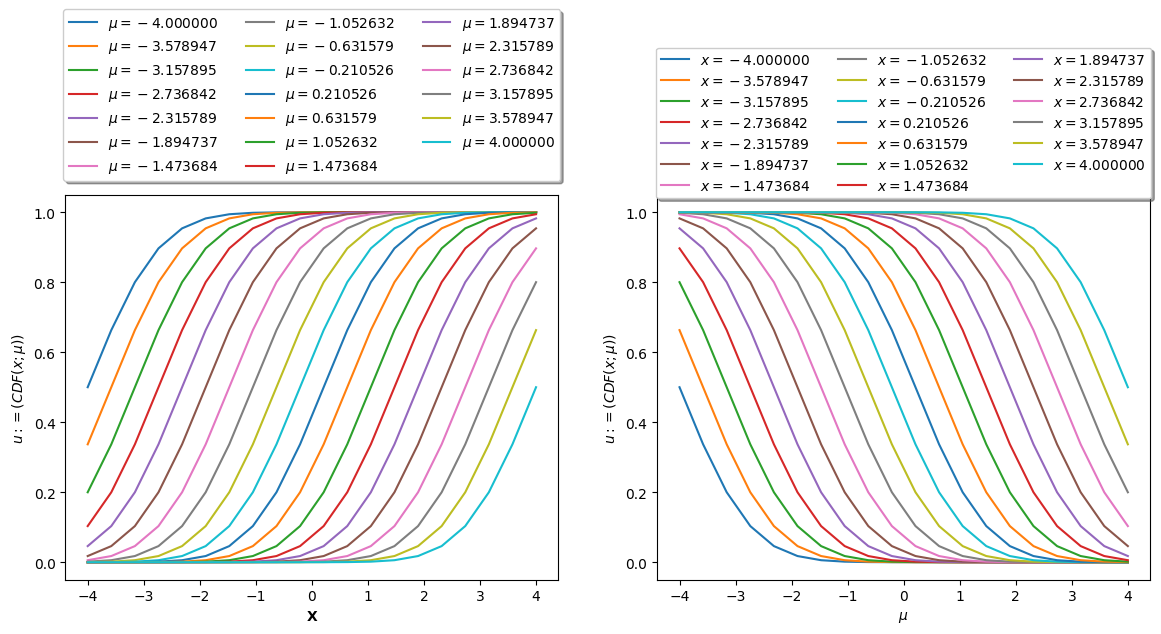

In [3]:
import numpy as np
import distributions
import matplotlib.pyplot as plt
plt.rc({"text.usetex": True})

# Number of discretization gridpoints (NOTE: larger --> better approximation but expensive)
num_gridpoints = 20

# Plot x as a function of the Gaussian mean (for fixed variance of 1)
x_vals = np.linspace(-4, 4, num_gridpoints)
mu_vals = np.linspace(-4, 4, num_gridpoints)
u_for_fixed_mu = []
for mu in mu_vals:
    g = distributions.OneDimensionalGaussian(mean=mu)
    u_for_fixed_mu.append([g.cdf(x) for x in x_vals])
    
u_for_fixed_x = []
for x in x_vals:
    u_for_fixed_x.append([distributions.OneDimensionalGaussian(mean=mu).cdf(x) for mu in mu_vals])
        
fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(121)
for i, mu in enumerate(mu_vals):
    ax.plot(x_vals, u_for_fixed_mu[i], label=r"$\mu=%f$"%(mu))
ax.set_xlabel("$\mathbf{X}$")
ax.set_ylabel("$u:=(CDF(x; \mu))$")
_ = ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.50), fancybox=True, shadow=True)

ax = fig.add_subplot(122)
for i, x in enumerate(x_vals):
    ax.plot(mu_vals, u_for_fixed_x[i], label=r"$x=%f$"%(x))
ax.set_xlabel("$\mu$")
ax.set_ylabel("$u:=(CDF(x; \mu))$")
_ = ax.legend(ncol=3, loc='upper center', bbox_to_anchor=(0.5, 1.40), fancybox=True, shadow=True)

### Chain Rule Application
- We want to numerically evaluate: $\frac{\partial x}{\partial \mu} = \frac{\partial CDF^{-1}(u; \mu)}{\partial u}|_{u=CDF(x)} \frac{\partial CDF(x; \mu)}{\partial \mu} $

Text(0.5, 0.92, '$\\frac{\\partial x}{\\partial \\mu}$')

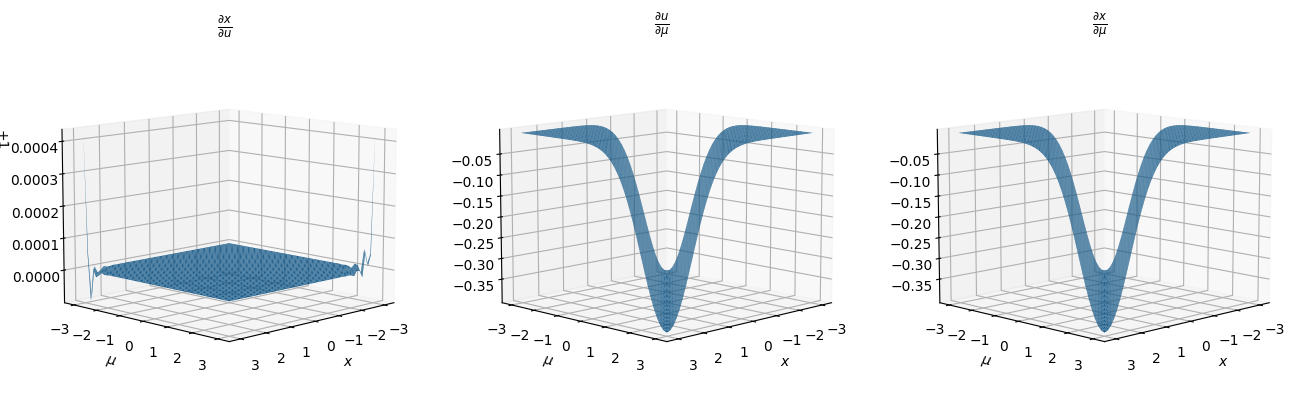

In [4]:
import numpy as np
import distributions
import matplotlib.pyplot as plt
plt.rc({"text.usetex": True})

def fd_derivative(func, x, eps=1e-5):
    """Simple function to evaluate finite difference derivative of a function"""
    return (func(x+eps) - func(x-eps)) / (2*eps)

# Number of discretization gridpoints (NOTE: larger --> better approximation but expensive)
num_gridpoints = 50

# Plot x as a function of the Gaussian mean (for fixed variance of 1)
x_vals = np.linspace(-3, 3, num_gridpoints)
mu_vals = np.linspace(-3, 3, num_gridpoints)
x_grid, mu_grid = np.meshgrid(x_vals, mu_vals, indexing='xy')
u_del_mu = np.empty_like(x_grid)
x_del_u = np.empty_like(x_grid)

for i in range(num_gridpoints):
    for j in range(num_gridpoints):
        x = x_grid[i, j]
        mu = mu_grid[i, j]
        
        u_del_mu[i, j] = fd_derivative(
            lambda v: distributions.OneDimensionalGaussian(mean=v).cdf(x=x),
            mu
        )
        x_del_u[i, j] = fd_derivative(
            lambda v: distributions.OneDimensionalGaussian(mean=mu).icdf(p=distributions.OneDimensionalGaussian(mean=mu).cdf(x=v)),
            x
        )
        # print(f"x={x}; mu={mu}; u_del_mu={u_del_mu[i, j]}; x_del_u={x_del_u[i, j]}; x_del_mu={x_del_u[i, j] * u_del_mu[i, j]}")

# EValuate derivative of x w.r.t mu by chain rul
x_del_mu = np.multiply(x_del_u, u_del_mu )   

## 3D plot of partial derivatives

# Figure:
fig = plt.figure(figsize=(16, 8))

# 3D plot of partial derivatives of x w.r.t. mu
ax = fig.add_subplot(131, projection='3d')
ax.view_init(elev=10, azim=45, roll=0)
ax.plot_surface(x_grid, mu_grid, x_del_u.T)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\mu$")
ax.set_title(r"$\frac{\partial x}{\partial u}$")

# 3D plot of partial derivatives of u w.r.t. mu
ax = fig.add_subplot(132, projection='3d')
ax.view_init(elev=10, azim=45, roll=0)
ax.plot_surface(x_grid, mu_grid, u_del_mu.T)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\mu$")
ax.set_title(r"$\frac{\partial u}{\partial \mu}$")

ax = fig.add_subplot(133, projection='3d')
ax.view_init(elev=10, azim=45, roll=0)
ax.plot_surface(x_grid, mu_grid, x_del_mu.T)
ax.set_xlabel(r"$x$")
ax.set_ylabel(r"$\mu$")
ax.set_title(r"$\frac{\partial x}{\partial \mu}$")

Looking closely at these figures we see that
- basically: <mark>**the numerical derivative $\frac{\partial x}{\partial \mu}$ given by automatic differentiation (torch backprob) is actually:**</mark>
    $$\frac{\partial u}{\partial \mu} = \frac{\partial CDF(x; \mu)}{\partial \mu}|{x} \,,$$
- This is also obvious because $\frac{\partial x}{\partial u}|_{u=CDF(x)}=1$ 



## N Dimensional Analysis

# General Notes

- In order to utilize derivative information properly in an optimization framework, the score function must be either:
    - a function of densities $f(x; \mu)$, the probability density function
        - Binning: $\rightarrow$ *histogram(ish) approach*
        - ML $\rightarrow$ KL-Divergence Minimization:
            \begin{align*}
                \arg\min_{\theta}D_{KL}(P \| Q) &= \arg\min_{\theta} \mathbb{E}_{x \sim P}[-\log Q_\theta(X)] - \mathcal{H}(P(X))\\
                &= \arg\min_{\theta} \mathbb{E}_{x \sim P}[-\log Q_\theta(X)]\\
                &= \arg\max_{\theta} \mathbb{E}_{x \sim P}[\log Q_\theta(X)] \,,
            \end{align*}
          where $X$ signifies observed data points, $P$ is the actual unknown distribution, and $Q$ is the parameterized distribution that we know (theory) with parameter $\theta$.
          
    - a function of cumulative densitities $u(x; \mu)$, the cumulative density function (or uniform values)  $\rightarrow$ KS(ish)!
 
- One would want to fit a cumulative density function curve to observations, and then compare $u=CDF$ values from observation to those from theory, and minimize accordingly. *This is straightforward in 1D.*
- In multi-dimensions, one would need to slice the space, and repeat the procedure forming a score function that is the sum of scores across slices.